In [1]:
from dgm_utils import train_model
from dgm_utils import show_samples, visualize_images, load_dataset
from dgm_utils import BaseModel

In [2]:
import numpy as np
import matplotlib.pyplot as plt

from typing import Optional, Literal

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data as data

if torch.cuda.is_available():
    DEVICE = "cuda"
    print('GPU found :)') 
else: 
    DEVICE = "cpu"
    print('GPU not found :(')

GPU found :)


C:\Users\twoli\AppData\Roaming\Python\Python310\site-packages\torchvision\transforms\functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


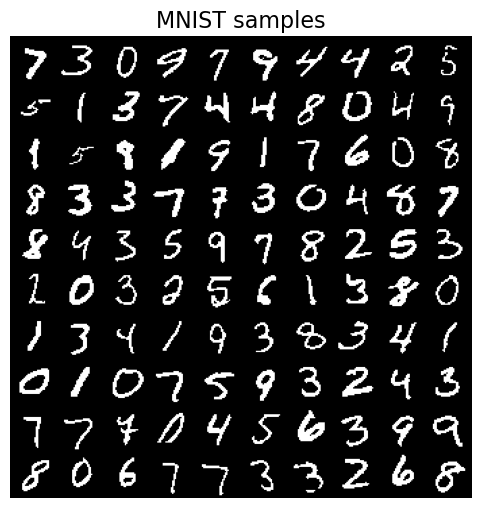

In [3]:
train_data, test_data = load_dataset("mnist", flatten=False, binarize=True)
visualize_images(train_data.astype(float), "MNIST samples")

In [4]:
class MaskedConv2d(nn.Conv2d):
    def __init__(
        self, mask_type: Literal['A', 'B'], in_channels: int, out_channels: int, kernel_size: int = 5
    ) -> None:
        assert mask_type in ["A", "B"]
        super().__init__(
            in_channels=in_channels,
            out_channels=out_channels,
            kernel_size=kernel_size,
            padding=kernel_size // 2,
        )
        # register_buffer() registers the tensor as a non-trainable buffer:
        # 1. It stays on the same device as the model (moves with .to(device)).
        # 2. It is not updated during backpropagation (not a learnable parameter).
        self.register_buffer("mask", torch.zeros_like(self.weight))
        self.create_mask(mask_type)

    def forward(self, input: torch.Tensor) -> torch.Tensor:
        return F.conv2d(input, self.weight * self.mask, self.bias, padding=self.padding)

    def create_mask(self, mask_type: Literal['A', 'B']) -> None:
        # NOTE: try to understand the logic about mask_type
        k = self.kernel_size[0]
        self.mask[:, :, : k // 2] = 1
        self.mask[:, :, k // 2, : k // 2] = 1
        if mask_type == "B":
            self.mask[:, :, k // 2, k // 2] = 1

In [5]:
class LayerNorm(nn.LayerNorm):
    def __init__(self, n_filters: int) -> None:
        super().__init__(n_filters)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = x.permute(0, 2, 3, 1).contiguous()
        x = super().forward(x)
        return x.permute(0, 3, 1, 2).contiguous()

In [6]:
class PixelCNN(BaseModel):
    def __init__(
        self,
        input_shape: tuple[int, int],
        n_filters: int = 64,
        kernel_size: int = 7,
        n_layers: int = 5,
        use_layer_norm: bool = True,
    ) -> None:

        super().__init__()
        self.input_shape = input_shape

        # we apply the sequence of MaskedConv2d -> LayerNorm (it is optional) -> ReLU
        # the last layer should be MaskedConv2d (not ReLU)
        # Note 1: the first conv layer should be of type 'A'
        # Note 2: final output_dim in MaskedConv2d must be 2
        model: list[nn.Module] = [MaskedConv2d("A", 1, n_filters, kernel_size=kernel_size)]

        for _ in range(n_layers):
            if use_layer_norm:
                model.append(LayerNorm(n_filters))
            model.append(nn.ReLU())
            model.append(MaskedConv2d("B", n_filters, n_filters, kernel_size=kernel_size))

        model.append(nn.ReLU())
        model.append(MaskedConv2d("B", in_channels=n_filters, out_channels=2, kernel_size=1))
        self.net = nn.Sequential(*model)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        batch_size = x.shape[0]
        out = (x.float() - 0.5) / 0.5
        out = self.net(out)
        return out.view(batch_size, 2, 1, *self.input_shape)

    def loss(self, x: torch.Tensor) -> dict:
        # our loss is just cross entropy
        total_loss = F.cross_entropy(self(x), x.long())
        return {"total_loss": total_loss}

    @torch.no_grad()
    def sample(self, n: int) -> np.ndarray:
        # read carefully the sampling process
        # here you see the sequential process of sampling
        samples = torch.zeros(n, 1, *self.input_shape).to(self.device)
        for r in range(self.input_shape[0]):
            for c in range(self.input_shape[1]):
                logits = self(samples)[:, :, :, r, c]
                probs = F.softmax(logits, dim=1).squeeze(-1)
                samples[:, 0, r, c] = torch.multinomial(probs, num_samples=1).squeeze(-1)
        return samples.cpu().numpy()

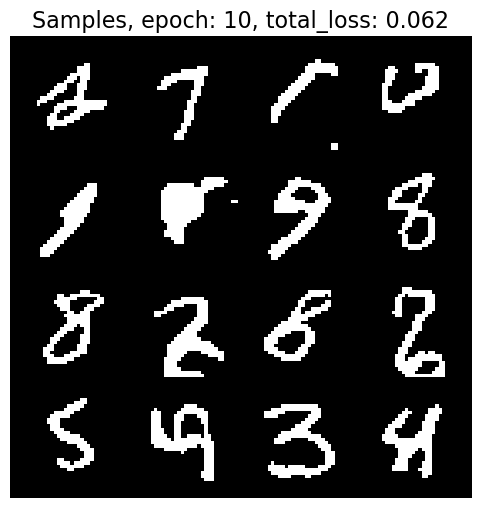

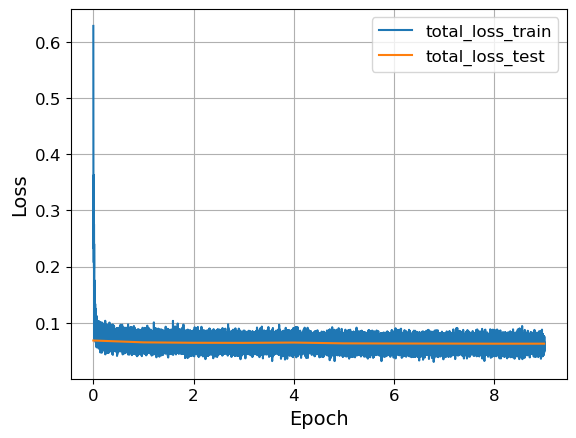

End of the training


In [7]:
# ====
# your code
# choose these parameters
EPOCHS = 10
BATCH_SIZE = 5
LR = 1e-4
N_LAYERS = 5
N_FILTERS = 64
USE_LAYER_NORM = True
# ====

pixel_cnn = PixelCNN(
    input_shape=(32, 32),
    n_filters=N_FILTERS,
    kernel_size=7,
    n_layers=N_LAYERS,
    use_layer_norm=USE_LAYER_NORM,
)

train_loader = data.DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True)
test_loader = data.DataLoader(test_data, batch_size=BATCH_SIZE)

# choose any optimizer/scheduler as you want
optimizer = torch.optim.Adam(pixel_cnn.parameters(), lr=LR)

train_model(
    pixel_cnn,
    train_loader,
    test_loader,
    epochs=EPOCHS,
    optimizer=optimizer,
    device=DEVICE,
    n_samples=16, # Remember the infernce is slow, so, you can lower the value 
    visualize_samples=True # or you can turn off smapling by setting `visualize_samples=False`
)

In [13]:
class PixelCNNAutoComplete(PixelCNN):
    @torch.no_grad()
    def sample(self, n: int, init: Optional[torch.Tensor] = None) -> np.ndarray:
        # ====
        # your code
        # this method almost the same as the method of the base PixelCNN model
        # but now if init is given, this tensor will be used as a starting image.
        # NOTE: fill the pixels only with value equals to -1 in the input tensor.

        # read carefully the sampling process
        # here you see the sequential process of sampling
        samples = torch.zeros(n, 1, *self.input_shape).to(self.device)
        if init is not None:
            samples = init.to(self.device)
        for r in range(self.input_shape[0]):
            for c in range(self.input_shape[1]):
                logits = self(samples)[:, :, :, r, c]
                probs = F.softmax(logits, dim=1).squeeze(-1)
                samples[:, 0, r, c] = torch.multinomial(probs, num_samples=1).squeeze(-1)
        return samples.cpu().numpy()

In [ ]:
pixel_cnn_ac = PixelCNNAutoComplete(
    input_shape=(32, 32),
    n_filters=N_FILTERS,
    kernel_size=7,
    n_layers=N_LAYERS,
    use_layer_norm=USE_LAYER_NORM,
)

pixel_cnn_ac.load_state_dict(pixel_cnn.state_dict())

<All keys matched successfully>

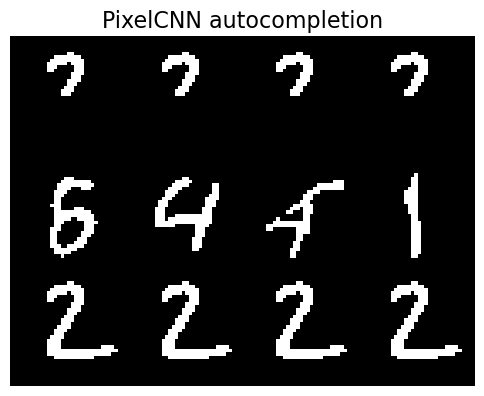

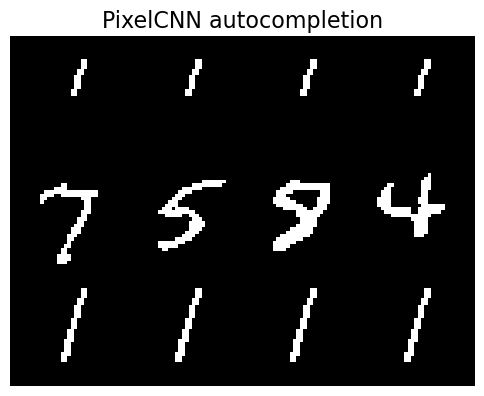

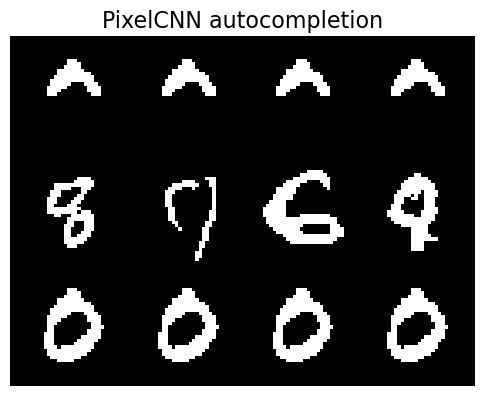

In [15]:
def autocomplete_image(
    original_image: np.ndarray, 
    model: PixelCNNAutoComplete, 
    n_samples: int
) -> None:
    # Remove lower half of the image
    original_image = np.repeat(original_image[None, :, :, :], n_samples, axis=0)
    masked_image = original_image.copy()
    masked_image[:, :, masked_image.shape[2] // 2 :, :] = -1
    
    # Generate completions
    generated_image = model.sample(n_samples, torch.tensor(masked_image).to(model.device))  
    images_to_show = np.concatenate([np.maximum(masked_image, 0), generated_image, original_image], axis=0)
    show_samples(images_to_show.astype(float), title="PixelCNN autocompletion", nrow=n_samples)

for i in range(1, 4):
    autocomplete_image(test_data[i], pixel_cnn_ac, n_samples=4)

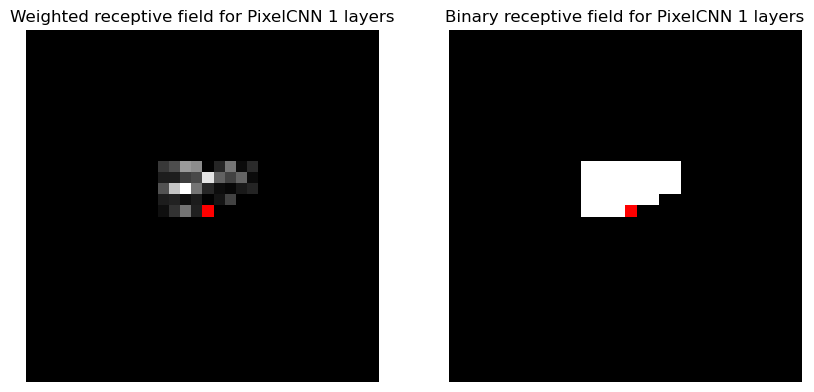

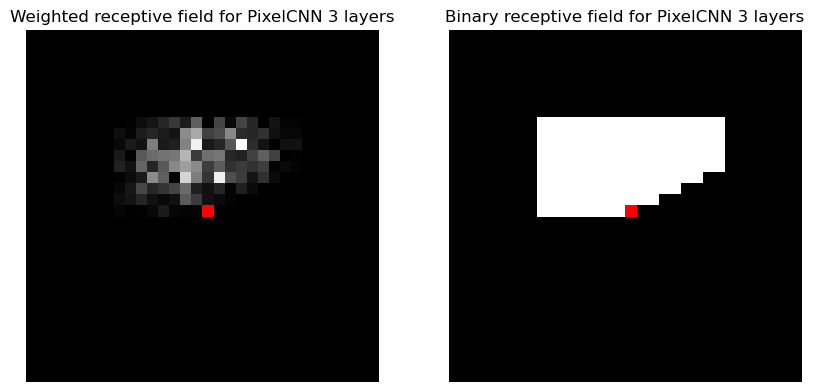

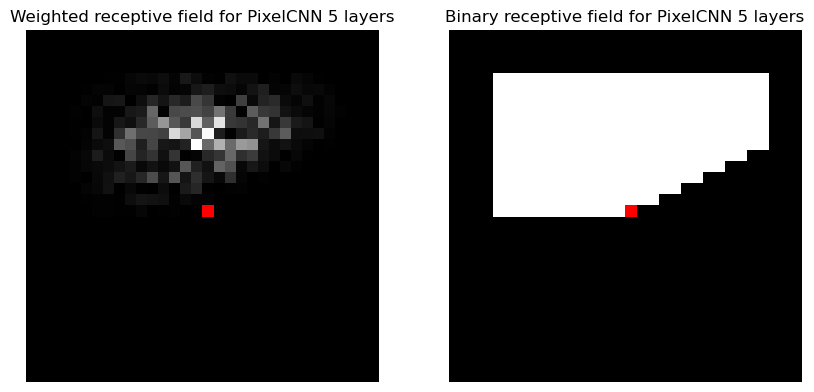

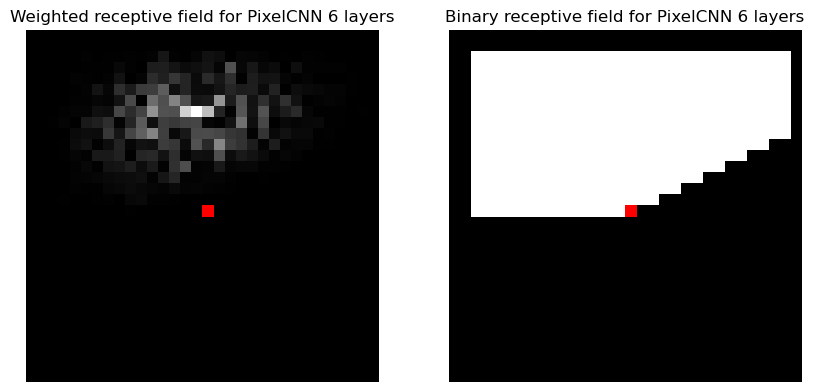

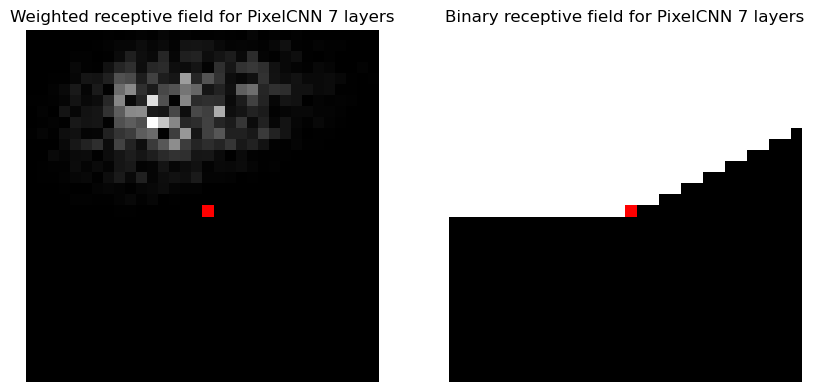

In [48]:
def plot_receptive_field(model: nn.Module, model_name: str) -> None:
    # ====
    # your code
    # 1) create tensor with zeros and set required_grad to True.
    input_tensor = torch.zeros(1, 1, 32, 32, requires_grad=True)
    # 2) apply model to the tensor
    output = model(input_tensor)
    # 3) apply backward() to the center pixel of model output
    output_shape = output.shape[-2:]
    x_center = output_shape[0] // 2
    y_center = output_shape[1] // 2
    target_pixel = torch.zeros_like(output)
    target_pixel[0, :, :, x_center, y_center] = 1
    output.backward(target_pixel)
    # 4) take the gradient with respect to input
    input_gradient = input_tensor.grad[0,0]
    # 5) binary receptive field is an indicator map in which we stay 1's if absolute gradient more than 1e-8
    binary_map = (input_gradient.abs() > 1e-8).float()
    # 6) weighted receptive field is the normalized absolute gradient (values lies in [0, 1])
    weighted_map = input_gradient.abs() / input_gradient.abs().max()
    # ====

    # we stack the maps to get RGB image
    binary_map = np.stack([binary_map, binary_map, binary_map], axis=-1)
    weighted_map = np.stack([weighted_map, weighted_map, weighted_map], axis=-1)

    # center point will be red
    binary_map[x_center, y_center] = [1, 0, 0]
    weighted_map[x_center, y_center] = [1, 0, 0]

    fig, ax = plt.subplots(1, 2, figsize=(10, 6))
    ax[0].imshow(weighted_map, vmin=0.0, vmax=1.0)
    ax[1].imshow(binary_map, vmin=0.0, vmax=1.0)

    ax[0].set_title(f"Weighted receptive field for {model_name}")
    ax[1].set_title(f"Binary receptive field for {model_name}")

    ax[0].axis("off")
    ax[1].axis("off")
    plt.show()

for n_layers in [1, 3, 5, 6, 7]:
    model = PixelCNN(
        input_shape=(32, 32),
        n_filters=32,
        kernel_size=5,
        n_layers=n_layers,
        use_layer_norm=True
    )
    model = model
    plot_receptive_field(model, model_name=f"PixelCNN {n_layers} layers")

In [4]:
class MultiheadAttention(nn.MultiheadAttention):
    def __init__(self, embed_dim: int, num_heads: int) -> None:
        super().__init__(embed_dim, num_heads)

    def get_attention_mask(self, x: torch.Tensor) -> torch.Tensor:
        # ====
        # your code
        # define attention mask, it should contain
        # - zeros under and on the main diagonal
        # - minus Inf above the main diagonal
        attention_mask = torch.ones(x.size(0), x.size(0))
        attention_mask = attention_mask * torch.tensor(-np.inf)
        attention_mask = torch.triu(attention_mask, diagonal=1)
        # ====
        return attention_mask

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        attn_mask = self.get_attention_mask(x)
        return super().forward(x, x, x, attn_mask=attn_mask, need_weights=False)[0]


def test_attention_mask() -> None:
    x = torch.zeros(2, 4, 16)  # (pixel_num, batch_size, emb_dim)
    mask = np.array([[0.0, -np.inf], [0.0, 0.0]])
    layer = MultiheadAttention(16, 8)
    attention_mask = layer.get_attention_mask(x)
    assert attention_mask.size() == (x.size(0), x.size(0))
    assert np.allclose(attention_mask.numpy(), mask)
    out = layer(x)
    assert x.size() == out.size()


test_attention_mask()

In [5]:
class TransformerBlock(nn.Module):
    def __init__(self, embed_dim: int, num_heads: int) -> None:
        super().__init__()
        assert embed_dim % num_heads == 0

        # ====
        # your code
        # define multihead attention (https://pytorch.org/docs/stable/generated/torch.nn.MultiheadAttention.html)
        self.multihead_attention = MultiheadAttention(embed_dim, num_heads)
        # define LayerNorm (https://pytorch.org/docs/stable/generated/torch.nn.LayerNorm.html)
        self.layer_norm1 = nn.LayerNorm(embed_dim)
        # (here we do not use previous class for LayerNorm because we do not need to change order of tensor dimensions)
        # define MLP - 2 linear layers with ReLU
        self.mlp = nn.Sequential(
            nn.Linear(embed_dim, embed_dim * 2),
            nn.ReLU(),
            nn.Linear(embed_dim * 2, embed_dim)
        )
        # (You could choose the latent dimensionality of MLP as you like. For example, double the embed_dim)
        self.layer_norm2 = nn.LayerNorm(embed_dim)
        # ====

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        # ====
        # your code
        # here you have to implement formulas that described above.
        n = self.layer_norm1(x)
        a = x + self.multihead_attention(n)
        x = a + self.mlp(self.layer_norm2(a))
        # ====
        return x


def test_decoder_block() -> None:
    block = TransformerBlock(embed_dim=12, num_heads=4)
    x = torch.zeros(4, 28, 12)
    assert x.shape == block(x).shape


test_decoder_block()

In [ ]:
class ImageGPT(BaseModel):
    def __init__(
        self, input_shape: tuple[int, int], embed_dim: int, num_heads: int, num_layers: int
    ) -> None:
        super().__init__()

        self.embed_dim = embed_dim
        self.input_shape = input_shape
        self.criterion = nn.BCEWithLogitsLoss()

        # "start of sequence" token (we initialize it from Normal distribution)
        self.sos = nn.Parameter(torch.zeros(embed_dim))

        # ====
        # your code
        # 1) define token_embeddings (we will have 2 embeddings in total, because our images are binary)
        self.token_embeddings = nn.Embedding(2, embed_dim)
        # 2) define position_embeddings (we will use nn.Embedding)
        self.position_embeddings = nn.Embedding(input_shape[0] * input_shape[1], embed_dim)
        # ====

        self.layers = nn.ModuleList()
        # ====
        # your code
        # 1) add decoder blocks to self.layers list
        for _ in range(num_layers):
            self.layers.append(TransformerBlock(embed_dim, num_heads))
        # 2) define last LayerNorm
        self.layer_norm = nn.LayerNorm(embed_dim)
        # 3) define final Linear layer (without bias)
        self.linear = nn.Linear(embed_dim, 1, bias=False)

        # ====

    def add_sos_token(self, embeddings: torch.Tensor) -> torch.Tensor:
        batch_size = embeddings.size(1)
        # ====
        # your code
        # prepend sos (start of sequence) token
        # 1) repeat sos token batch_size times (make it of size (1, batch_size, emd_size))
        sos_token = self.sos.repeat(1, batch_size, 1)
        # 2) drop last embedding from embeddings
        embeddings = embeddings[:-1]
        # 3) concat repeated sos token to embeddings (after dropping)
        embeddings = torch.cat([sos_token, embeddings], dim=0)

        # ====
        return embeddings

    def add_pos_embeddings(self, embeddings: torch.Tensor) -> torch.Tensor:
        length = embeddings.size(0)
        # ====
        # your code
        # add positional embeddings
        # 1) define tensor with positions (just torch.arange) of size (length, 1)
        positions = torch.arange(length).unsqueeze(1).to(DEVICE)
        # 2) add position embeddings to initial embeddings
        positions_embeddings = self.position_embeddings(positions)
        embeddings = embeddings + positions_embeddings

        # ====
        return embeddings

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = x.long()
        x = x.reshape(x.size(0), -1)  # (batch_size, length)
        x = x.permute(1, 0)

        embeddings = self.token_embeddings(x)  # (length, batch_size, emb_size)
        embeddings = self.add_sos_token(embeddings)
        embeddings = self.add_pos_embeddings(embeddings)

        # ====
        # your code
        # 1) apply all decoder layers
        for layer in self.layers:
            embeddings = layer(embeddings)
        # 2) apply final LayerNorm and Linear layer
        embeddings = self.layer_norm(embeddings)
        logits = self.linear(embeddings)    
        # ====

        return logits.permute(1, 0, 2)  # (length, batch_size, emb_size) -> (batch_size, length, emb_size)

    def loss(self, x: torch.Tensor) -> dict:
        logits = self(x)
        loss = self.criterion(logits.reshape(-1), x.reshape(-1).float())
        return {"total_loss": loss}

    @torch.no_grad()
    def sample(self, n_samples: int) -> np.ndarray:
        # read sampling carefully
        seq_len = self.input_shape[0] * self.input_shape[1]
        samples = torch.zeros(n_samples, seq_len).long().to(self.device)
        for i in range(seq_len):
            logits = self(samples)
            dist = torch.distributions.Bernoulli(logits=logits[:, i, 0])
            samples[:, i] = dist.sample()
        samples = samples.reshape(n_samples, 1, *self.input_shape)
        return samples.cpu().numpy().astype(float)


def test_image_gpt() -> None:
    image_gpt = ImageGPT(input_shape=(2, 2), embed_dim=12, num_heads=4, num_layers=2)
    x = torch.LongTensor([[0, 1, 0, 0], [0, 1, 1, 1]])
    assert image_gpt(x).shape == torch.Size([2, 4, 1])
    assert image_gpt.loss(x)["total_loss"].requires_grad == True
    assert image_gpt.sample(1).shape == torch.Size([1, 1, 2, 2])


test_image_gpt()

In [19]:
# ====
# your code
# choose these parameters
EPOCHS = 15
BATCH_SIZE = 10
LR = 1e-3

EMB_DIM = 12
NUM_HEADS = 4
NUM_LAYERS = 5
# ====

image_gpt = ImageGPT((32, 32), EMB_DIM, NUM_HEADS, NUM_LAYERS)

train_loader = data.DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True)
test_loader = data.DataLoader(test_data, batch_size=BATCH_SIZE)

# choose any optimizer/scheduler as you want
optimizer = torch.optim.Adam(image_gpt.parameters(), lr=LR)

train_model(
    image_gpt,
    train_loader,
    test_loader,
    epochs=EPOCHS,
    optimizer=optimizer,
    device=DEVICE,
    n_samples=16, # Remember the infernce is slow, so, you can lower the value 
    visualize_samples=True # or you can turn off smapling by setting `visualize_samples=False`
)

Start of the training


Training epoch 1:   0%|          | 0/6000 [00:00<?, ?it/s]

RuntimeError: Expected all tensors to be on the same device, but found at least two devices, cuda:0 and cpu! (when checking argument for argument index in method wrapper_CUDA__index_select)